In [ ]:
!pip install plyfile PyMCubes trimesh open3d opencv-python

In [1]:
import os
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm, trange


In [2]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

In [3]:
def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
    r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

    Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

    Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
    """
    # TESTED
    # Only works for the last dimension (dim=-1)
    dim = -1
    # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
    cumprod = torch.cumprod(tensor, dim)
    # "Roll" the elements along dimension 'dim' by 1 element.
    cumprod = torch.roll(cumprod, 1, dim)
    # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
    cumprod[..., 0] = 1.0

    return cumprod

def get_minibatches(inputs: torch.Tensor, chunksize: Optional[int] = 1024 * 8):
    r"""Takes a huge tensor (ray "bundle") and splits it into a list of minibatches.
    Each element of the list (except possibly the last) has dimension `0` of length
    `chunksize`.
    """
    return [inputs[i : i + chunksize] for i in range(0, inputs.shape[0], chunksize)]


def meshgrid_xy(
    tensor1: torch.Tensor, tensor2: torch.Tensor
) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)

def get_ray_bundle(
    height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor
):
    r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

    Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

    Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    """
    # TESTED
    ii, jj = meshgrid_xy(
        torch.arange(
            width, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ).to(tform_cam2world),
        torch.arange(
            height, dtype=tform_cam2world.dtype, device=tform_cam2world.device
        ),
    )
    directions = torch.stack(
        [
            (ii - width * 0.5) / focal_length,
            -(jj - height * 0.5) / focal_length,
            -torch.ones_like(ii),
        ],
        dim=-1,
    )
    ray_directions = torch.sum(
        directions[..., None, :] * tform_cam2world[:3, :3], dim=-1
    )
    ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
    return ray_origins, ray_directions

def positional_encoding(
    tensor, num_encoding_functions=6, include_input=True, log_sampling=True
) -> torch.Tensor:
    r"""Apply positional encoding to the input.

    Args:
        tensor (torch.Tensor): Input tensor to be positionally encoded.
        encoding_size (optional, int): Number of encoding functions used to compute
            a positional encoding (default: 6).
        include_input (optional, bool): Whether or not to include the input in the
            positional encoding (default: True).

    Returns:
    (torch.Tensor): Positional encoding of the input tensor.
    """
    # TESTED
    # Trivially, the input tensor is added to the positional encoding.
    encoding = [tensor] if include_input else []
    frequency_bands = None
    if log_sampling:
        frequency_bands = 2.0 ** torch.linspace(
            0.0,
            num_encoding_functions - 1,
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )
    else:
        frequency_bands = torch.linspace(
            2.0 ** 0.0,
            2.0 ** (num_encoding_functions - 1),
            num_encoding_functions,
            dtype=tensor.dtype,
            device=tensor.device,
        )

    for freq in frequency_bands:
        for func in [torch.sin, torch.cos]:
            encoding.append(func(tensor * freq))

    # Special case, for no positional encoding
    if len(encoding) == 1:
        return encoding[0]
    else:
        return torch.cat(encoding, dim=-1)

In [4]:
def compute_query_points_from_rays(
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    near_thresh: float,
    far_thresh: float,
    num_samples: int,
    randomize: Optional[bool] = True,
) -> (torch.Tensor, torch.Tensor):
    r"""Compute query 3D points given the "bundle" of rays. The near_thresh and far_thresh
    variables indicate the bounds within which 3D points are to be sampled.

    Args:
        ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
          `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
        ray_directions (torch.Tensor): Direction of each ray in the "bundle" as returned by the
          `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
        near_thresh (float): The 'near' extent of the bounding volume (i.e., the nearest depth
          coordinate that is of interest/relevance).
        far_thresh (float): The 'far' extent of the bounding volume (i.e., the farthest depth
          coordinate that is of interest/relevance).
        num_samples (int): Number of samples to be drawn along each ray. Samples are drawn
          randomly, whilst trying to ensure "some form of" uniform spacing among them.
        randomize (optional, bool): Whether or not to randomize the sampling of query points.
          By default, this is set to `True`. If disabled (by setting to `False`), we sample
          uniformly spaced points along each ray in the "bundle".

    Returns:
        query_points (torch.Tensor): Query points along each ray
          (shape: :math:`(width, height, num_samples, 3)`).
        depth_values (torch.Tensor): Sampled depth values along each ray
          (shape: :math:`(num_samples)`).
    """
    # TESTED
    # shape: (num_samples)
    depth_values = torch.linspace(near_thresh, far_thresh, num_samples).to(ray_origins)
    if randomize is True:
        # ray_origins: (width, height, 3)
        # noise_shape = (width, height, num_samples)
        noise_shape = list(ray_origins.shape[:-1]) + [num_samples]
        # depth_values: (num_samples)
        depth_values = (
            depth_values
            + torch.rand(noise_shape).to(ray_origins)
            * (far_thresh - near_thresh)
            / num_samples
        )
    # (width, height, num_samples, 3) = (width, height, 1, 3) + (width, height, 1, 3) * (num_samples, 1)
    # query_points:  (width, height, num_samples, 3)
    query_points = (
        ray_origins[..., None, :]
        + ray_directions[..., None, :] * depth_values[..., :, None]
    )
    # TODO: Double-check that `depth_values` returned is of shape `(num_samples)`.
    return query_points, depth_values




In [5]:
def render_volume_density(
    radiance_field: torch.Tensor, ray_origins: torch.Tensor, depth_values: torch.Tensor
) -> (torch.Tensor, torch.Tensor, torch.Tensor):
    r"""Differentiably renders a radiance field, given the origin of each ray in the
    "bundle", and the sampled depth values along them.

    Args:
    radiance_field (torch.Tensor): A "field" where, at each query location (X, Y, Z),
      we have an emitted (RGB) color and a volume density (denoted :math:`\sigma` in
      the paper) (shape: :math:`(width, height, num_samples, 4)`).
    ray_origins (torch.Tensor): Origin of each ray in the "bundle" as returned by the
      `get_ray_bundle()` method (shape: :math:`(width, height, 3)`).
    depth_values (torch.Tensor): Sampled depth values along each ray
      (shape: :math:`(num_samples)`).

    Returns:
    rgb_map (torch.Tensor): Rendered RGB image (shape: :math:`(width, height, 3)`).
    depth_map (torch.Tensor): Rendered depth image (shape: :math:`(width, height)`).
    acc_map (torch.Tensor): # TODO: Double-check (I think this is the accumulated
      transmittance map).
    """
    # TESTED
    sigma_a = torch.nn.functional.relu(radiance_field[..., 3])
    rgb = torch.sigmoid(radiance_field[..., :3])
    one_e_10 = torch.tensor([1e10], dtype=ray_origins.dtype, device=ray_origins.device)
    dists = torch.cat(
        (
            depth_values[..., 1:] - depth_values[..., :-1],
            one_e_10.expand(depth_values[..., :1].shape),
        ),
        dim=-1,
    )
    alpha = 1.0 - torch.exp(-sigma_a * dists)
    weights = alpha * cumprod_exclusive(1.0 - alpha + 1e-10)

    rgb_map = (weights[..., None] * rgb).sum(dim=-2)
    depth_map = (weights * depth_values).sum(dim=-1)
    acc_map = weights.sum(-1)

    return rgb_map, depth_map, acc_map



In [6]:
# One iteration of TinyNeRF (forward pass).
def run_one_iter_of_tinynerf(
    height,
    width,
    focal_length,
    tform_cam2world,
    near_thresh,
    far_thresh,
    depth_samples_per_ray,
    encoding_function,
    get_minibatches_function,
    chunksize,
    model,
    encoding_function_args,
):

    # Get the "bundle" of rays through all image pixels.
    ray_origins, ray_directions = get_ray_bundle(
        height, width, focal_length, tform_cam2world
    )

    # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

    # "Flatten" the query points.
    flattened_query_points = query_points.reshape((-1, 3))

    # Encode the query points (default: positional encoding).
    encoded_points = encoding_function(flattened_query_points, encoding_function_args)

    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    batches = get_minibatches_function(encoded_points, chunksize=chunksize)
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)

    # "Unflatten" to obtain the radiance field.
    unflattened_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_predicted, _, _ = render_volume_density(
        radiance_field, ray_origins, depth_values
    )

    return rgb_predicted

In [7]:
class VeryTinyNerfModel(torch.nn.Module):
    r"""Define a "very tiny" NeRF model comprising three fully connected layers.
    """

    def __init__(self, filter_size=128, num_encoding_functions=6):
        super(VeryTinyNerfModel, self).__init__()
        # Input layer (default: 39 -> 128)
        self.layer1 = torch.nn.Linear(3 + 3 * 2 * num_encoding_functions, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 4)
        self.layer3 = torch.nn.Linear(filter_size, 4)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

In [8]:
# def main():

# Determine device to run on (GPU vs CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Log directory
logdir = os.path.join("./", "cache", "log")
os.makedirs(logdir, exist_ok=True)

"""
Load input images and poses
"""

data = np.load("cache/tiny_nerf_data.npz")

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]
tform_cam2world = torch.from_numpy(tform_cam2world).to(device)
# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

# Height and width of each image
height, width = images.shape[1:3]

# Near and far clipping thresholds for depth values.
near_thresh = 2.0
far_thresh = 6.0

# Hold one image out (for test).
testimg, testpose = images[101], tform_cam2world[101]
testimg = torch.from_numpy(testimg).to(device)

# Map images to device
images = torch.from_numpy(images[:100, ..., :3]).to(device)

"""
Parameters for TinyNeRF training
"""

# Number of functions used in the positional encoding (Be sure to update the
# model if this number changes).
num_encoding_functions = 10
# Specify encoding function.
encode = positional_encoding
# Number of depth samples along each ray.
depth_samples_per_ray = 32

# Chunksize (Note: this isn't batchsize in the conventional sense. This only
# specifies the number of rays to be queried in one go. Backprop still happens
# only after all rays from the current "bundle" are queried and rendered).
# Use chunksize of about 4096 to fit in ~1.4 GB of GPU memory (when using 8
# samples per ray).
chunksize = 4096

# Optimizer parameters
lr = 5e-3
num_iters = 5000

# Misc parameters
display_every = 100  # Number of iters after which stats are

weightpath = 'weight_smallnerf.tensor'


cuda


In [8]:

"""
Model
"""
model = VeryTinyNerfModel(filter_size=256, num_encoding_functions=num_encoding_functions)
model.to(device)

"""
Optimizer
"""
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

"""
Train-Eval-Repeat!
"""

# Seed RNG, for repeatability
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Lists to log metrics etc.
psnrs = []
iternums = []

for i in trange(num_iters):

    # Randomly pick an image as the target.
    target_img_idx = np.random.randint(images.shape[0])
    target_img = images[target_img_idx].to(device)
    target_tform_cam2world = tform_cam2world[target_img_idx].to(device)

    # Run one iteration of TinyNeRF and get the rendered RGB image.
    rgb_predicted = run_one_iter_of_tinynerf(
        height,
        width,
        focal_length,
        target_tform_cam2world,
        near_thresh,
        far_thresh,
        depth_samples_per_ray,
        encode,
        get_minibatches,
        chunksize,
        model,
        num_encoding_functions,
    )

    # Compute mean-squared error between the predicted and target images. Backprop!
    loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Display images/plots/stats
    if i % display_every == 0 or i == num_iters - 1:
        # Render the held-out view
        rgb_predicted = run_one_iter_of_tinynerf(
            height,
            width,
            focal_length,
            testpose,
            near_thresh,
            far_thresh,
            depth_samples_per_ray,
            encode,
            get_minibatches,
            chunksize,
            model,
            num_encoding_functions,
        )
        loss = torch.nn.functional.mse_loss(rgb_predicted, target_img)
        tqdm.write("Loss: " + str(loss.item()))
        psnr = -10.0 * torch.log10(loss)

        psnrs.append(psnr.item())
        iternums.append(i)

        plt.imshow(rgb_predicted.detach().cpu().numpy())
        plt.savefig(os.path.join(logdir, str(i).zfill(6) + ".png"))
        plt.close("all")

        if i == num_iters - 1:
            plt.plot(iternums, psnrs)
            plt.savefig(os.path.join(logdir, "psnr.png"))
            plt.close("all")
        # plt.figure(figsize=(10, 4))
        # plt.subplot(121)
        # plt.imshow(rgb_predicted.detach().cpu().numpy())
        # plt.title(f"Iteration {i}")
        # plt.subplot(122)
        # plt.plot(iternums, psnrs)
        # plt.title("PSNR")
        # plt.show()

# save model
torch.save(model.state_dict(), weightpath)
print('Model saved: ', weightpath)

print("Done!")

cuda


  0%|          | 0/5000 [00:00<?, ?it/s]/home/ivan/work/deep_learning/env/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 1/5000 [00:00<1:00:01,  1.39it/s]

Loss: 0.13439476490020752


  2%|▏         | 101/5000 [00:09<09:07,  8.94it/s]

Loss: 0.03292996063828468


  4%|▍         | 201/5000 [00:19<08:56,  8.94it/s]

Loss: 0.09915251284837723


  6%|▌         | 301/5000 [00:28<09:46,  8.01it/s]

Loss: 0.09950590878725052


  8%|▊         | 401/5000 [00:37<09:37,  7.96it/s]

Loss: 0.07002642750740051


 10%|█         | 501/5000 [00:47<09:35,  7.82it/s]

Loss: 0.05126650631427765


 12%|█▏        | 602/5000 [00:57<08:18,  8.82it/s]

Loss: 0.1020662784576416


 14%|█▍        | 702/5000 [01:07<08:37,  8.31it/s]

Loss: 0.09770140051841736


 16%|█▌        | 801/5000 [01:17<08:33,  8.17it/s]

Loss: 0.094502292573452


 18%|█▊        | 901/5000 [01:27<08:43,  7.83it/s]

Loss: 0.06869138777256012


 20%|██        | 1001/5000 [01:37<08:07,  8.21it/s]

Loss: 0.03834882751107216


 22%|██▏       | 1101/5000 [01:47<09:39,  6.73it/s]

Loss: 0.06542065739631653


 24%|██▍       | 1201/5000 [01:57<07:42,  8.21it/s]

Loss: 0.09396331012248993


 26%|██▌       | 1301/5000 [02:08<09:03,  6.81it/s]

Loss: 0.08573585003614426


 28%|██▊       | 1401/5000 [02:18<08:24,  7.13it/s]

Loss: 0.08662672340869904


 30%|███       | 1501/5000 [02:29<08:51,  6.58it/s]

Loss: 0.10860954225063324


 32%|███▏      | 1601/5000 [02:39<08:49,  6.41it/s]

Loss: 0.09193383902311325


 34%|███▍      | 1701/5000 [02:50<09:30,  5.78it/s]

Loss: 0.10374308377504349


 36%|███▌      | 1801/5000 [03:01<08:21,  6.38it/s]

Loss: 0.08454485982656479


 38%|███▊      | 1901/5000 [03:12<07:12,  7.16it/s]

Loss: 0.15183430910110474


 40%|████      | 2001/5000 [03:23<08:10,  6.12it/s]

Loss: 0.1505047082901001


 42%|████▏     | 2101/5000 [03:34<08:56,  5.40it/s]

Loss: 0.0980093851685524


 44%|████▍     | 2201/5000 [03:46<07:55,  5.89it/s]

Loss: 0.11471690982580185


 46%|████▌     | 2301/5000 [03:57<07:08,  6.29it/s]

Loss: 0.1351412683725357


 48%|████▊     | 2401/5000 [04:09<07:12,  6.01it/s]

Loss: 0.09593947231769562


 50%|█████     | 2501/5000 [04:20<06:41,  6.23it/s]

Loss: 0.11577392369508743


 52%|█████▏    | 2601/5000 [04:32<06:43,  5.94it/s]

Loss: 0.08700563758611679


 54%|█████▍    | 2701/5000 [04:43<06:15,  6.13it/s]

Loss: 0.07829128950834274


 56%|█████▌    | 2801/5000 [04:54<05:55,  6.18it/s]

Loss: 0.1450328826904297


 58%|█████▊    | 2901/5000 [05:05<05:48,  6.02it/s]

Loss: 0.11069931834936142


 60%|██████    | 3001/5000 [05:17<05:21,  6.21it/s]

Loss: 0.09801377356052399


 62%|██████▏   | 3101/5000 [05:28<05:22,  5.89it/s]

Loss: 0.1050148755311966


 64%|██████▍   | 3201/5000 [05:39<04:50,  6.18it/s]

Loss: 0.11291451007127762


 66%|██████▌   | 3301/5000 [05:50<04:36,  6.14it/s]

Loss: 0.08457420021295547


 68%|██████▊   | 3401/5000 [06:02<04:20,  6.15it/s]

Loss: 0.08687779307365417


 70%|███████   | 3501/5000 [06:13<04:09,  6.00it/s]

Loss: 0.060993604362010956


 72%|███████▏  | 3601/5000 [06:24<03:50,  6.07it/s]

Loss: 0.09828370064496994


 74%|███████▍  | 3701/5000 [06:35<03:37,  5.97it/s]

Loss: 0.07785339653491974


 76%|███████▌  | 3801/5000 [06:47<03:36,  5.54it/s]

Loss: 0.09434845298528671


 78%|███████▊  | 3901/5000 [06:58<02:55,  6.26it/s]

Loss: 0.07807058095932007


 80%|████████  | 4001/5000 [07:10<02:45,  6.05it/s]

Loss: 0.10588207840919495


 82%|████████▏ | 4101/5000 [07:21<02:55,  5.13it/s]

Loss: 0.06435585021972656


 84%|████████▍ | 4201/5000 [07:32<02:09,  6.18it/s]

Loss: 0.09151618927717209


 86%|████████▌ | 4301/5000 [07:44<01:55,  6.03it/s]

Loss: 0.07621742784976959


 88%|████████▊ | 4401/5000 [07:55<01:38,  6.09it/s]

Loss: 0.07013960182666779


 90%|█████████ | 4501/5000 [08:06<01:22,  6.05it/s]

Loss: 0.08407662063837051


 92%|█████████▏| 4601/5000 [08:17<01:05,  6.12it/s]

Loss: 0.08266570419073105


 94%|█████████▍| 4701/5000 [08:29<00:50,  5.96it/s]

Loss: 0.130642831325531


 96%|█████████▌| 4801/5000 [08:40<00:31,  6.23it/s]

Loss: 0.10243937373161316


 98%|█████████▊| 4901/5000 [08:51<00:16,  6.12it/s]

Loss: 0.14907431602478027


100%|█████████▉| 4999/5000 [09:02<00:00,  8.97it/s]

Loss: 0.05705239996314049


100%|██████████| 5000/5000 [09:02<00:00,  9.21it/s]

Done!


## Render 360 video 

In [10]:
# Render 360

trans_t = lambda t : torch.tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=torch.float32)

rot_phi = lambda phi : torch.tensor([
    [1,0,0,0],
    [0,np.cos(phi),-np.sin(phi),0],
    [0,np.sin(phi), np.cos(phi),0],
    [0,0,0,1],
], dtype=torch.float32)

rot_theta = lambda th : torch.tensor([
    [np.cos(th),0,-np.sin(th),0],
    [0,1,0,0],
    [np.sin(th),0, np.cos(th),0],
    [0,0,0,1],
], dtype=torch.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180. * torch.pi) @ c2w
    c2w = rot_theta(theta/180.*torch.pi) @ c2w
    c2w = torch.tensor([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]).float() @ c2w
    return c2w


In [11]:
frames = []
with torch.no_grad():
    for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
        c2w = pose_spherical(th, -30., 4.)
        # Get the "bundle" of rays through all image pixels.
        ray_origins, ray_directions = get_ray_bundle(
            height, width, focal_length, c2w.to(device)
        )

        # Sample query points along each ray
        query_points, depth_values = compute_query_points_from_rays(
            ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
        )

        # "Flatten" the query points.
        flattened_query_points = query_points.reshape((-1, 3))

        # Encode the query points (default: positional encoding).
        encoded_points = encode(flattened_query_points, num_encoding_functions)

        # Split the encoded points into "chunks", run the model on all chunks, and
        # concatenate the results (to avoid out-of-memory issues).
        batches = get_minibatches(encoded_points, chunksize=chunksize)
        predictions = []
        for batch in batches:
            predictions.append(model(batch))
        radiance_field_flattened = torch.cat(predictions, dim=0)

        # "Unflatten" to obtain the radiance field.
        unflattened_shape = list(query_points.shape[:-1]) + [4]
        radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

        # Perform differentiable volume rendering to re-synthesize the RGB image.
        rgb_predicted, _, _ = render_volume_density(
            radiance_field, ray_origins, depth_values
            )
        frames += [np.array(rgb_predicted.cpu()*255).astype(np.uint8)]


100%|██████████| 120/120 [00:05<00:00, 21.57it/s]


In [145]:
# query_points.unique()

tensor([-3.0416, -3.0125, -3.0054,  ...,  2.3350,  2.3372,  2.3478],
       device='cuda:0')

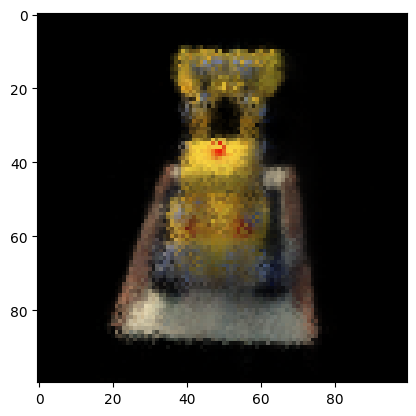

In [12]:
plt.imshow(rgb_predicted.cpu())

In [13]:
import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (100, 100) to (112, 112) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).
[swscaler @ 0x637b700] Warning: data is not aligned! This can lead to a speed loss


## 3D model rendering

In [31]:
model = VeryTinyNerfModel(filter_size=256, num_encoding_functions=num_encoding_functions)

In [32]:
model.load_state_dict(torch.load(weightpath))


<All keys matched successfully>

In [33]:
model = model.to(device)

In [34]:
chunk = 1024*32

In [42]:
### Tune these parameters until the whole object lies tightly in range with little noise ###
N = 100 #128 # controls the resolution, set this number small here because we're only finding
        # good ranges here, not yet for mesh reconstruction; we can set this number high
        # when it comes to final reconstruction.
xmin, xmax = -1.2, 1.2 # left/right range
ymin, ymax = -1.2, 1.2 # forward/backward range
zmin, zmax = -0.2, 1.2 # up/down range
## Attention! the ranges MUST have the same length!
sigma_threshold = 5. # controls the noise (lower=maybe more noise; higher=some mesh might be missing)
############################################################################################

x = np.linspace(xmin, xmax, N)
y = np.linspace(ymin, ymax, N)
z = np.linspace(zmin, zmax, N)

xyz_ = torch.tensor(np.stack(np.meshgrid(x, y, z), -1).reshape(-1, 3)).float()
dir_ = torch.zeros_like(xyz_)

In [43]:
with torch.no_grad():
    B = xyz_.shape[0]
    out_chunks = []
    for i in range(0, B, chunk):
        encoded_points = encode(xyz_[i:i+chunk].to(device), num_encoding_functions)
        out_chunks += [model(encoded_points)]

    rgbsigma = torch.cat(out_chunks, 0)


In [44]:
sigma = rgbsigma[:, -1].cpu().numpy()
sigma = np.maximum(sigma, 0)
sigma = sigma.reshape(N, N, N)
# sigma = np.transpose(sigma, axes=(0,2,1))

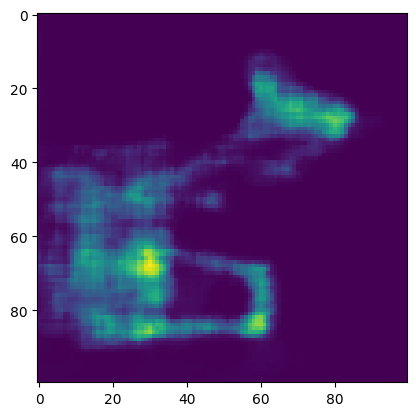

In [45]:
plt.imshow(sigma[:,55])

In [46]:
import mcubes
import trimesh

In [47]:
# The below lines are for visualization, COMMENT OUT once you find the best range and increase N!
vertices, triangles = mcubes.marching_cubes(sigma, sigma_threshold)
mesh = trimesh.Trimesh(vertices/N, triangles)
mesh.show()

## Color mesh

In [48]:
vertices_ = (vertices/N).astype(np.float32)
## invert x and y coordinates (WHY? maybe because of the marching cubes algo)
x_ = (ymax-ymin) * vertices_[:, 1] + ymin
y_ = (xmax-xmin) * vertices_[:, 0] + xmin
vertices_[:, 0] = x_
vertices_[:, 1] = y_
vertices_[:, 2] = (zmax-zmin) * vertices_[:, 2] + zmin
vertices_.dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4')]

face = np.empty(len(triangles), dtype=[('vertex_indices', 'i4', (3,))])
face['vertex_indices'] = triangles

In [51]:
from plyfile import PlyData, PlyElement

scene_name = 'test'

PlyData([PlyElement.describe(vertices_[:, 0], 'vertex'), 
             PlyElement.describe(face, 'face')]).write(f'{scene_name}.ply')

In [55]:
import open3d 
# remove noise in the mesh by keeping only the biggest cluster
print('Removing noise ...')
mesh = open3d.io.read_triangle_mesh(f"{scene_name}.ply")
idxs, count, _ = mesh.cluster_connected_triangles()
max_cluster_idx = np.argmax(count)
triangles_to_remove = [i for i in range(len(face)) if idxs[i] != max_cluster_idx]
mesh.remove_triangles_by_index(triangles_to_remove)
mesh.remove_unreferenced_vertices()
print(f'Mesh has {len(mesh.vertices)/1e6:.2f} M vertices and {len(mesh.triangles)/1e6:.2f} M faces.')

vertices_ = np.asarray(mesh.vertices).astype(np.float32)
triangles = np.asarray(mesh.triangles)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Removing noise ...
Mesh has 0.03 M vertices and 0.05 M faces.


In [58]:
# perform color prediction
# Step 0. define constants (image width, height and intrinsics)
W, H = 100, 100
K = torch.tensor([[focal_length, 0, width/2],
                [0, focal_length, height/2],
                [0,             0,   1]]).float()

In [83]:
image, vertices_image[i:i+remap_chunk, 0],vertices_image[i:i+remap_chunk, 1]

(array([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],
 
        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], dtype=float32),
 tensor([61.6079, 61.8081, 61.6146,  ...

In [84]:
import cv2

# Images
images = data["images"]
# Camera extrinsics (poses)
tform_cam2world = data["poses"]

# Step 1. transform vertices into world coordinate
N_vertices = len(vertices_)
vertices_homo = np.concatenate([vertices_, np.ones((N_vertices, 1))], 1) # (N, 4)

## buffers to store the final averaged color
non_occluded_sum = np.zeros((N_vertices, 1))
v_color_sum = np.zeros((N_vertices, 3))

# Step 2. project the vertices onto each training image to infer the color
n_images = images.shape[0]
print('Fusing colors ...')
for idx in tqdm(range(n_images)):
    ## read image of this pose
    image = images[idx]
    ## read the camera to world relative pose
    P_c2w = tform_cam2world[idx] #np.concatenate([tform_cam2world[idx], np.array([0, 0, 0, 1]).reshape(1, 4)], 0)
    P_w2c = np.linalg.inv(P_c2w)[:3] # (3, 4)


    ## project vertices from world coordinate to camera coordinate
    vertices_cam = (P_w2c @ vertices_homo.T) # (3, N) in "right up back"
    vertices_cam[1:] *= -1 # (3, N) in "right down forward"
    ## project vertices from camera coordinate to pixel coordinate
    vertices_image = (K @ vertices_cam).T # (N, 3)
    depth = vertices_image[:, -1:]+1e-5 # the depth of the vertices, used as far plane
    vertices_image = vertices_image[:, :2]/depth
    vertices_image = vertices_image.float() #.astype(np.float32)
    vertices_image[:, 0] = np.clip(vertices_image[:, 0], 0, W-1)
    vertices_image[:, 1] = np.clip(vertices_image[:, 1], 0, H-1)

    ## compute the color on these projected pixel coordinates
    ## using bilinear interpolation.
    ## NOTE: opencv's implementation has a size limit of 32768 pixels per side,
    ## so we split the input into chunks.
    colors = []
    remap_chunk = int(3e4)
    for i in range(0, N_vertices, remap_chunk):
        colors += [cv2.remap(image, 
                            np.array(vertices_image[i:i+remap_chunk, 0]),
                            np.array(vertices_image[i:i+remap_chunk, 1]),
                            interpolation=cv2.INTER_LINEAR)[:, 0]]
    colors = np.vstack(colors) # (N_vertices, 3)


    ## predict occlusion of each vertex
    ## we leverage the concept of NeRF by constructing rays coming out from the camera
    ## and hitting each vertex; by computing the accumulated opacity along this path,
    ## we can know if the vertex is occluded or not.
    ## for vertices that appear to be occluded from every input view, we make the
    ## assumption that its color is the same as its neighbors that are facing our side.
    ## (think of a surface with one side facing us: we assume the other side has the same color)

    ## ray's origin is camera origin
    rays_o = torch.FloatTensor(tform_cam2world[idx][:, -1]).expand(N_vertices, 3)
    ## ray's direction is the vector pointing from camera origin to the vertices
    rays_d = torch.FloatTensor(vertices_) - rays_o # (N_vertices, 3)
    rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
    near = near_thresh * torch.ones_like(rays_o[:, :1]) #dataset.bounds.min() * torch.ones_like(rays_o[:, :1])
    ## the far plane is the depth of the vertices, since what we want is the accumulated
    ## opacity along the path from camera origin to the vertices
    far = torch.FloatTensor(depth) * torch.ones_like(rays_o[:, :1])
    
    break
    # results = f([nerf_fine], embeddings,
    #             torch.cat([rays_o, rays_d, near, far], 1).cuda(),
    #             args.N_samples,
    #             0,
    #             args.chunk,
    #             dataset.white_back)
    
    # opacity = results['opacity_coarse'].cpu().numpy()[:, np.newaxis] # (N_vertices, 1)
    # opacity = np.nan_to_num(opacity, 1)


    # non_occluded = np.ones_like(non_occluded_sum) * 0.1/depth # weight by inverse depth
    #                                                         # near=more confident in color
    # non_occluded += opacity < args.occ_threshold
    
    # v_color_sum += colors * non_occluded
    # non_occluded_sum += non_occluded
            

Fusing colors ...


  0%|          | 0/106 [00:00<?, ?it/s]

  0%|          | 0/106 [00:00<?, ?it/s]


RuntimeError: The expanded size of the tensor (3) must match the existing size (4) at non-singleton dimension 1.  Target sizes: [27574, 3].  Tensor sizes: [4]

In [66]:
def get_results_for_color(model, rays_o, rays_d, near, far, chunk):
    # Get the "bundle" of rays through all image pixels.
    ray_origins, ray_directions = get_ray_bundle(
        height, width, focal_length, tform_cam2world
    )

    # Sample query points along each ray
    query_points, depth_values = compute_query_points_from_rays(
        ray_origins, ray_directions, near_thresh, far_thresh, depth_samples_per_ray
    )

    # "Flatten" the query points.
    flattened_query_points = query_points.reshape((-1, 3))

    # Encode the query points (default: positional encoding).
    encoded_points = encode(flattened_query_points, num_encoding_functions)

    # Split the encoded points into "chunks", run the model on all chunks, and
    # concatenate the results (to avoid out-of-memory issues).
    batches = get_minibatches(encoded_points, chunksize=chunksize)
    predictions = []
    for batch in batches:
        predictions.append(model(batch))
    radiance_field_flattened = torch.cat(predictions, dim=0)

    # "Unflatten" to obtain the radiance field.
    unflattened_shape = list(query_points.shape[:-1]) + [4]
    radiance_field = torch.reshape(radiance_field_flattened, unflattened_shape)

    # Perform differentiable volume rendering to re-synthesize the RGB image.
    rgb_predicted, _, _ = render_volume_density(
        radiance_field, ray_origins, depth_values
    )


(106, 4, 4)

In [ ]:
import cv2
use_vertex_normal = False

# Step 1. transform vertices into world coordinate
N_vertices = len(vertices_)
vertices_homo = np.concatenate([vertices_, np.ones((N_vertices, 1))], 1) # (N, 4)

if use_vertex_normal: ## use normal vector method as suggested by the author.
                            ## see https://github.com/bmild/nerf/issues/44
    mesh.compute_vertex_normals()
    rays_d = torch.FloatTensor(np.asarray(mesh.vertex_normals))
    near = dataset.bounds.min() * torch.ones_like(rays_d[:, :1])
    far = dataset.bounds.max() * torch.ones_like(rays_d[:, :1])
    rays_o = torch.FloatTensor(vertices_) - rays_d * near * args.near_t

    nerf_coarse = NeRF()
    load_ckpt(nerf_coarse, args.ckpt_path, model_name='nerf_coarse')
    nerf_coarse.cuda().eval()

    results = f([nerf_coarse, nerf_fine], embeddings,
                torch.cat([rays_o, rays_d, near, far], 1).cuda(),
                args.N_samples,
                args.N_importance,
                args.chunk,
                dataset.white_back)

else: ## use my color average method. see README_mesh.md
    ## buffers to store the final averaged color
    non_occluded_sum = np.zeros((N_vertices, 1))
    v_color_sum = np.zeros((N_vertices, 3))

    # Step 2. project the vertices onto each training image to infer the color
    print('Fusing colors ...')
    for idx in tqdm(range(len(dataset.image_paths))):
        ## read image of this pose
        image = Image.open(dataset.image_paths[idx]).convert('RGB')
        image = image.resize(tuple(args.img_wh), Image.LANCZOS)
        image = np.array(image)

        ## read the camera to world relative pose
        P_c2w = np.concatenate([dataset.poses[idx], np.array([0, 0, 0, 1]).reshape(1, 4)], 0)
        P_w2c = np.linalg.inv(P_c2w)[:3] # (3, 4)
        ## project vertices from world coordinate to camera coordinate
        vertices_cam = (P_w2c @ vertices_homo.T) # (3, N) in "right up back"
        vertices_cam[1:] *= -1 # (3, N) in "right down forward"
        ## project vertices from camera coordinate to pixel coordinate
        vertices_image = (K @ vertices_cam).T # (N, 3)
        depth = vertices_image[:, -1:]+1e-5 # the depth of the vertices, used as far plane
        vertices_image = vertices_image[:, :2]/depth
        vertices_image = vertices_image.astype(np.float32)
        vertices_image[:, 0] = np.clip(vertices_image[:, 0], 0, W-1)
        vertices_image[:, 1] = np.clip(vertices_image[:, 1], 0, H-1)

        ## compute the color on these projected pixel coordinates
        ## using bilinear interpolation.
        ## NOTE: opencv's implementation has a size limit of 32768 pixels per side,
        ## so we split the input into chunks.
        colors = []
        remap_chunk = int(3e4)
        for i in range(0, N_vertices, remap_chunk):
            colors += [cv2.remap(image, 
                                vertices_image[i:i+remap_chunk, 0],
                                vertices_image[i:i+remap_chunk, 1],
                                interpolation=cv2.INTER_LINEAR)[:, 0]]
        colors = np.vstack(colors) # (N_vertices, 3)
        
        ## predict occlusion of each vertex
        ## we leverage the concept of NeRF by constructing rays coming out from the camera
        ## and hitting each vertex; by computing the accumulated opacity along this path,
        ## we can know if the vertex is occluded or not.
        ## for vertices that appear to be occluded from every input view, we make the
        ## assumption that its color is the same as its neighbors that are facing our side.
        ## (think of a surface with one side facing us: we assume the other side has the same color)

        ## ray's origin is camera origin
        rays_o = torch.FloatTensor(dataset.poses[idx][:, -1]).expand(N_vertices, 3)
        ## ray's direction is the vector pointing from camera origin to the vertices
        rays_d = torch.FloatTensor(vertices_) - rays_o # (N_vertices, 3)
        rays_d = rays_d / torch.norm(rays_d, dim=-1, keepdim=True)
        near = dataset.bounds.min() * torch.ones_like(rays_o[:, :1])
        ## the far plane is the depth of the vertices, since what we want is the accumulated
        ## opacity along the path from camera origin to the vertices
        far = torch.FloatTensor(depth) * torch.ones_like(rays_o[:, :1])
        results = f([nerf_fine], embeddings,
                    torch.cat([rays_o, rays_d, near, far], 1).cuda(),
                    args.N_samples,
                    0,
                    args.chunk,
                    dataset.white_back)
        opacity = results['opacity_coarse'].cpu().numpy()[:, np.newaxis] # (N_vertices, 1)
        opacity = np.nan_to_num(opacity, 1)

        non_occluded = np.ones_like(non_occluded_sum) * 0.1/depth # weight by inverse depth
                                                                # near=more confident in color
        non_occluded += opacity < args.occ_threshold
        
        v_color_sum += colors * non_occluded
        non_occluded_sum += non_occluded

In [ ]:
# Step 3. combine the output and write to file
if args.use_vertex_normal:
    v_colors = results['rgb_fine'].cpu().numpy() * 255.0
else: ## the combined color is the average color among all views
    v_colors = v_color_sum/non_occluded_sum
v_colors = v_colors.astype(np.uint8)
v_colors.dtype = [('red', 'u1'), ('green', 'u1'), ('blue', 'u1')]
vertices_.dtype = [('x', 'f4'), ('y', 'f4'), ('z', 'f4')]
vertex_all = np.empty(N_vertices, vertices_.dtype.descr+v_colors.dtype.descr)
for prop in vertices_.dtype.names:
    vertex_all[prop] = vertices_[prop][:, 0]
for prop in v_colors.dtype.names:
    vertex_all[prop] = v_colors[prop][:, 0]
    
face = np.empty(len(triangles), dtype=[('vertex_indices', 'i4', (3,))])
face['vertex_indices'] = triangles

PlyData([PlyElement.describe(vertex_all, 'vertex'), 
            PlyElement.describe(face, 'face')]).write(f'{args.scene_name}.ply')

print('Done!')